In [1]:
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import galsim
import batoid
import wfsim
from scipy.ndimage import rotate

import os
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.WfEstimator import WfEstimator
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.Utility import CamType, DefocalType, getConfigDir

import pickle

/astro/store/epyc/projects/lsst_comm/lsstinstall/conda/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
detectorLocations = {
    # bottom left
    "R00": (-0.02075, -0.02075),
    "R00_SW0": (-0.02075, -0.02075),
    "R00_SW1": (-0.02075, -0.02075),
    # top left
    "R40": (-0.02075, +0.02075),
    "R40_SW0": (-0.02075, +0.02075),
    "R40_SW1": (-0.02075, +0.02075),
    # bottom right
    "R04": (+0.02075, -0.02075),
    "R04_SW0": (+0.02075, -0.02075),
    "R04_SW1": (+0.02075, -0.02075),
    # top right
    "R44": (+0.02075, +0.02075),
    "R44_SW0": (+0.02075, +0.02075),
    "R44_SW1": (+0.02075, +0.02075),
}

def getBatoidSims(n, output_dir):                
    # determine the path
    path = Path(output_dir + f"/batoid/iter{n}.pkl")
                
    if not path.exists():
        # run and save simulations
        batoidDict = runBatoidSims(n, output_dir)
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, "wb") as file:
            pickle.dump(batoidDict, file)

    # load the batoid sims
    with open(path, "rb") as file:
        batoidDict = pickle.load(file)
                
    return batoidDict

def runBatoidSims(n, output_dir):
    # load the butler
    butler_repo = output_dir + "/phosimData"
    butler = Butler(butler_repo)
    registry = butler.registry
    
    # determine the collection to pull from
    collection = f"ts_phosim_{9006000 + n*10}"
    
    # get the phosim data references from the butler
    intraStampRefs = list(registry.queryDatasets(collections=collection, datasetType="donutStampsIntra"))
    extraStampRefs = list(registry.queryDatasets(collections=collection, datasetType="donutStampsExtra"))
    
    # load the opd
    opd = np.genfromtxt(output_dir + f"/iter{n}/img/opd.zer")
    
    # load the bandpass
    band = intraStampRefs[0].dataId["band"]
    bandpass = galsim.Bandpass(f"LSST_{band}.dat", wave_type="nm")
    
    # Setup observation parameters.  Making ~plausible stuff up.
    observation = {
        'zenith': 30 * galsim.degrees,
        'raw_seeing': 0.7 * galsim.arcsec,  # zenith 500nm seeing
        'wavelength': bandpass.effective_wavelength,
        'exptime': 15.0,  # seconds
        'temperature': 293.,  # Kelvin
        'pressure': 69.,  #kPa
        'H2O_pressure': 1.0  #kPa
    }

    # Setup atmospheric parameters
    atm_kwargs = {
        'screen_size': 819.2,
        'screen_scale': 0.1,
        'nproc': 6  # create screens in parallel using this many CPUs
    }
    
    # create a fiducial simulator
    rng = np.random.default_rng(0)
    lsst = batoid.Optic.fromYaml(f"LSST_{band}.yaml")
    simulator = wfsim.SimpleSimulator(
        observation,
        atm_kwargs,
        lsst,
        bandpass,
        name="R00_SW0",
        rng=rng
    )
    
    # setup WfEstimator
    wfEst = WfEstimator(f"{getConfigDir()}/cwfs/algo")
    wfEst.config(sizeInPix=160, units="um", algo="ml" if "ml" in output_dir else "exp")

    # create a dictionary to hold all the results
    batoidDict = {}
    
    for intraRef, extraRef, zk in zip(intraStampRefs, extraStampRefs, opd):
        
        # create the perturbed telescope
        R_outer = lsst.pupilSize / 2
        R_inner = R_outer * lsst.pupilObscuration
        phase = batoid.Zernike(
            np.pad(zk, pad_width=(4,0), mode='constant') * 1e-6,
            R_outer=R_outer,
            R_inner=R_inner,
        )
        perturbed = batoid.CompoundOptic(
                (
                    batoid.optic.OPDScreen(
                        batoid.Plane(),
                        phase,
                        name="PhaseScreen",
                        obscuration=batoid.ObscNegation(batoid.ObscCircle(5.0)),
                        coordSys=lsst.stopSurface.coordSys
                    ),
                    *lsst.items,
                ),
                name="PerturbedLSST",
                backDist=lsst.backDist,
                pupilSize=lsst.pupilSize,
                inMedium=lsst.inMedium,
                stopSurface=lsst.stopSurface,
                sphereRadius=lsst.sphereRadius,
                pupilObscuration=lsst.pupilObscuration
        )
    
        # load the stamps and zernikes
        intraStamp = butler.getDirect(intraRef)[0]
        extraStamp = butler.getDirect(extraRef)[0]

        # pull out the metadata we need for the intrafocal star
        fieldAngle, detector, nphotons, noise, sed = getStampMetaData(intraStamp)
        
        # create the intrafocal simulator
        intra = perturbed.withGloballyShiftedOptic("Detector", [0, 0, -0.0015])
        simulator.telescope = intra
        simulator.set_name(detector)
        
        # simulate the intrafocal star
        simulator.add_star(*fieldAngle, sed, nphotons, rng)
        simulator.add_background(noise, rng)
        
        # select stamp center
        x, y = np.array(simulator.wcs.radecToxy(*fieldAngle, galsim.radians))
        x = int(x - simulator.image.xmin)
        y = int(y - simulator.image.ymin)

        # determine stamp shape
        shape = intraStamp.stamp_im.getImage().array.shape
        dx, dy = shape[0] // 2, shape[1] // 2

        # cutout stamp
        intraBatoidStamp = simulator.image.array[y-dy:y+dy, x-dx:x+dx]
        
        # put the intrafocal stamp in the wavefront estimator
        wfEst.reset()
        wfEst.setImg(
            np.rad2deg(fieldAngle),
            DefocalType.Intra,
            image=intraBatoidStamp.copy(),
        )
        
        # pull out the metadata we need for the extrafocal star
        fieldAngle, detector, nphotons, noise, sed = getStampMetaData(extraStamp)
        
        # create the extrafocal simulator
        extra = perturbed.withGloballyShiftedOptic("Detector", [0, 0, +0.0015])
        simulator.telescope = extra
        simulator.set_name(detector)
        
        # simulate the intrafocal star
        simulator.add_star(*fieldAngle, sed, nphotons, rng)
        simulator.add_background(noise, rng)
        
        # select stamp center
        x, y = np.array(simulator.wcs.radecToxy(*fieldAngle, galsim.radians))
        x = int(x - simulator.image.xmin)
        y = int(y - simulator.image.ymin)

        # determine stamp shape
        shape = extraStamp.stamp_im.getImage().array.shape
        dx, dy = shape[0] // 2, shape[1] // 2

        # cutout stamp
        extraBatoidStamp = simulator.image.array[y-dy:y+dy, x-dx:x+dx]
        
        # put the extrafocal stamp in the wavefront estimator
        wfEst.setImg(
            np.rad2deg(fieldAngle),
            DefocalType.Extra,
            image=extraBatoidStamp.copy(),
        )
        
        # estimate zernikes from batoid sims
        zkBatoidEst = wfEst.calWfsErr()
        if "ml" in output_dir:
            zkBatoidEst /= bandpass.effective_wavelength / 1e3
        
        # calculate the "true" batoid zernikes
        zkBatoidTrue = batoid.zernike(
            perturbed,
            *detectorLocations[detector],
            1e-6,
            #bandpass.effective_wavelength * 1e-9,
            jmax=23,
        ) - batoid.zernike(
            lsst,
            *detectorLocations[detector],
            1e-6,
            #bandpass.effective_wavelength * 1e-9,
            jmax=23,
        )
        
        # store results in dictionary
        batoidDict[detector[:3]] = {
            "intra": intraBatoidStamp,
            "extra": extraBatoidStamp,
            "zernikes": zkBatoidEst,
            "truth": zkBatoidTrue,
        }

    return batoidDict
    
def getStampMetaData(stamp):
    # get the field angle
    fieldAngle = stamp.calcFieldXY() # degrees
    fieldAngle = np.deg2rad(fieldAngle) # -> radians
    
    # and the detector
    detector = stamp.detector_name
    
    # get the stamp image object
    img = stamp.comp_im.getImgObj()

    # get the number of photons to simulate
    imgMask = img._centroidFind.getImgBinary(img.image)
    nphotons = int(img.image[imgMask.astype(bool)].sum())

    # and the standard deviation of the background
    bgMask = 1 - imgMask
    noise = np.std(img.image[bgMask.astype(bool)])
    
    # pick a temperature
    T = 7_000 # K
    
    # make a blackbody SED
    sed = wfsim.BBSED(T)
    
    return fieldAngle, detector, nphotons, noise, sed
    

In [3]:
def plot_iteration(n, output_dir, batoid=True):
    # load the butler
    butler_repo = output_dir + "/phosimData"
    butler = Butler(butler_repo)
    registry = butler.registry

    # determine the collection to pull from
    collection = f"ts_phosim_{9006000 + n*10}"
    
    # get the data references from the butler
    intraStampRefs = list(registry.queryDatasets(collections=collection, datasetType="donutStampsIntra"))
    extraStampRefs = list(registry.queryDatasets(collections=collection, datasetType="donutStampsExtra"))
    zernikeRefs = list(registry.queryDatasets(collections=collection, datasetType="zernikeEstimateAvg"))
    
    # and the true zernikes
    opd = np.genfromtxt(output_dir + f"/iter{n}/img/opd.zer")
    
    if batoid:
        # get the batoid zernikes and stamps
        batoidDict = getBatoidSims(n, output_dir)
    
    # create the figure
    fig = plt.Figure(
        figsize=(10, 6),
        dpi=120,
        constrained_layout=True,
    )
    gs = fig.add_gridspec(4, 5, width_ratios=(1, 1, 3, 1, 1))
    
    # loop over rows
    for i, (intraRef, extraRef, zkRef, zkTrue) in enumerate(
        zip(
            intraStampRefs,
            extraStampRefs,
            zernikeRefs,
            opd,
        )
    ):
        
        # plot the intrafocal stamp
        intraStamp = butler.getDirect(intraRef)[0]
        img = intraStamp.stamp_im.getImage().getArray()
        detector = intraStamp.getCamera().get(intraStamp.detector_name)
        img = rotate(img, -detector.getOrientation().getYaw().asDegrees()).T
        ax0 = fig.add_subplot(gs[i, 0])
        ax0.imshow(img, origin="lower")
        ax0.set(xticks=[], yticks=[], ylabel=intraStamp.detector_name[:3])
        ax0.text(0.01, 0.92, "phosim", color="w", fontsize=7, transform=ax0.transAxes)
        
        # plot the extrafocal stamp
        extraStamp = butler.getDirect(extraRef)[0]
        img = extraStamp.stamp_im.getImage().getArray()
        detector = extraStamp.getCamera().get(extraStamp.detector_name)
        img = rotate(img, -detector.getOrientation().getYaw().asDegrees()).T
        ax1 = fig.add_subplot(gs[i, 1])
        ax1.imshow(img, origin="lower")
        ax1.set(xticks=[], yticks=[])
        ax1.text(0.01, 0.92, "phosim", color="w", fontsize=7, transform=ax1.transAxes)
        
        # plot the zernikes
        zernikes = butler.getDirect(zkRef)
        ax2 = fig.add_subplot(gs[i, 2])
        ax2.plot(np.arange(4, 23), zkTrue, c="k", ls="--", label="OPD")
        ax2.plot(np.arange(4, 23), zernikes, c="C0", label="phosim")
        ax2.set(
            xticks=np.arange(4, 23, 2), 
            xticklabels=[], 
            ylim=(-1.25, 1.25),
            yticks=np.arange(-1, 1.5, 0.5),
        )
        ax2.set_ylabel("$\mu m$", labelpad=-5)
        
        if batoid:
            
            batoidSims = batoidDict[extraStamp.detector_name[:3]]

            # plot the batoid zernikes
            www = 1 #galsim.Bandpass("LSST_g.dat", wave_type="nm").effective_wavelength / 1e3
            ax2.plot(np.arange(4, 23), -batoidSims["zernikes"], c="C1", label="batoid est.")
            ax2.plot(np.arange(4, 23), -batoidSims["truth"][4:-1]*www, c="C3", ls=":", label="batoid tr.")
            

            # plot the intrafocal batoid stamp
            ax3 = fig.add_subplot(gs[i, 3])
            ax3.imshow(batoidSims["intra"], origin="lower")
            ax3.set(xticks=[], yticks=[])
            ax3.text(0.01, 0.92, "batoid", color="w", fontsize=7, transform=ax3.transAxes)

            # plot the extrafocal batoid stamp
            ax4 = fig.add_subplot(gs[i, 4])
            ax4.imshow(batoidSims["extra"], origin="lower")
            ax4.set(xticks=[], yticks=[],)
            ax4.text(0.01, 0.92, "batoid", color="w", fontsize=7, transform=ax4.transAxes)
            ax4.set_ylabel(extraStamp.detector_name[:3], rotation=-90, labelpad=13)
            ax4.yaxis.set_label_position("right")
        
        # set labels and titles
        if i == 0:
            fig.suptitle(f"Iteration {n}", fontsize=16)
            ax0.set_title("Intra")
            ax1.set_title("Extra")
            ax2.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="center", borderaxespad=0, ncol=4, fontsize=8)
            if batoid:
                ax3.set_title("Intra")
                ax4.set_title("Extra")
        elif i == 3:
            ax2.set(xlabel="Zernike index (Noll)", xticklabels=np.arange(4, 23, 2))
            
    return fig

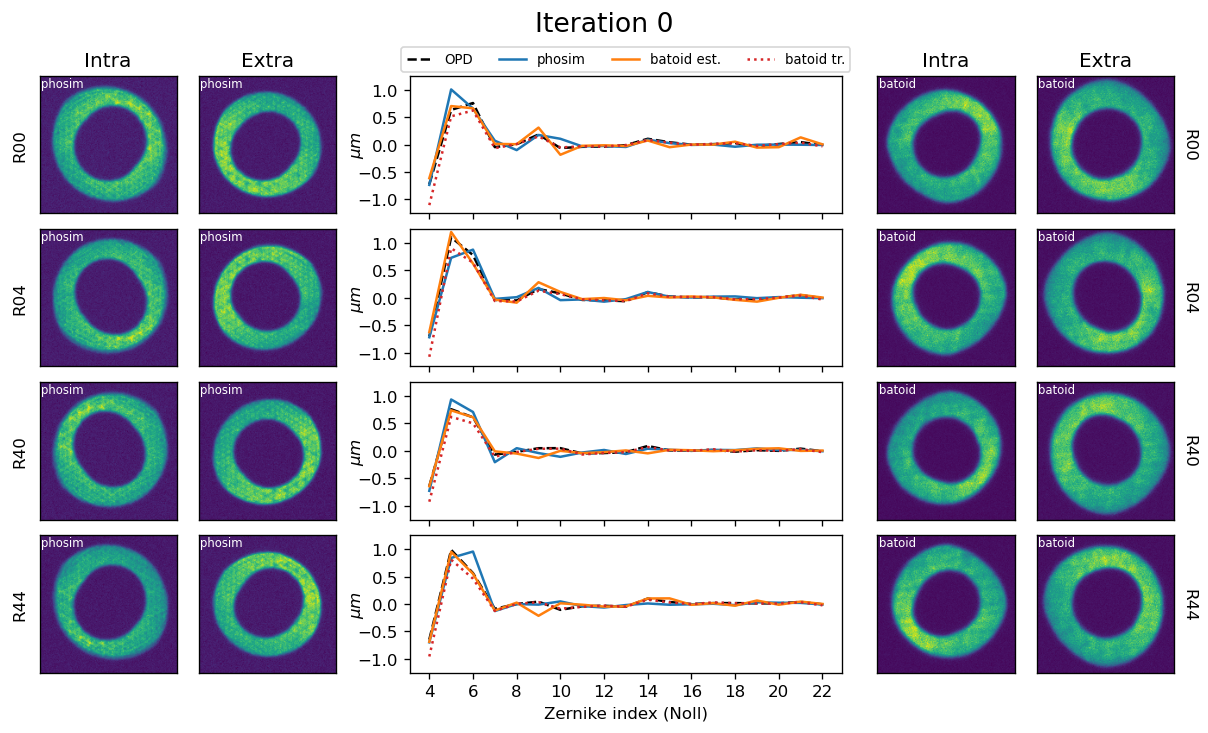

In [6]:
plot_iteration(0, "/phys/users/jfc20/lsst/exp_closedLoop_output3")